In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import numpy as np
from tqdm import tqdm

from nflows.flows.base import Flow
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.distributions.normal import ConditionalDiagonalNormal

In [2]:
training_data = np.load("../../Data/n1000000_0910_all_flat.npz")
data_all = np.column_stack([training_data['ve_dune'][:,:36], training_data['vu_dune'][:,:36], training_data['vebar_dune'][:,:36], training_data['vubar_dune'][:,:36]])

# theta13, theta23, delta, mumu, emu, etau
target = np.column_stack([training_data["theta13"]/180*np.pi, training_data["theta23"]/180*np.pi,
                         training_data["delta"]/180*np.pi])

split = 900000
x_train = data_all[:split]
y_train = target[:split]
x_train_poisson = np.random.poisson(x_train)/1000

x_val = data_all[split:]
y_val = target[split:]
x_val_poisson = np.random.poisson(x_val)/1000

In [3]:
num_layers = 5
base_dist = ConditionalDiagonalNormal(shape=[3], 
                                      context_encoder=nn.Linear(144, 6))

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=3))
    transforms.append(MaskedAffineAutoregressiveTransform(features=3, 
                                                          hidden_features=6, 
                                                          context_features=144))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [4]:
num_iter = 1000
for i in tqdm(range(num_iter)):
    x = torch.tensor(y_train, dtype=torch.float32)
    y = torch.tensor(x_train/1000, dtype=torch.float32)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x, context=y).mean()
    loss.backward()
    optimizer.step()

100%|██████████| 1/1 [00:35<00:00, 35.79s/it]


In [5]:
torch.save(flow, "./nf/test.pt")

In [38]:
n_sample = 10000
samples = flow.sample(num_samples=n_sample,
            context=torch.tensor(np.array([x_val[0]/1000]), dtype=torch.float32)).cpu().detach().numpy()

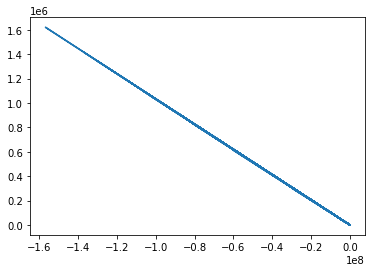

In [31]:
plt.plot(samples[:, 1], samples[:, 2])

In [19]:
cut = 10
xline = torch.linspace(0.13, 0.16, cut)
yline = torch.linspace(0.6, 0.9, cut)
zline = torch.linspace(0, 6.3, cut)
xgrid, ygrid, zgrid = torch.meshgrid(xline, yline, zline)
xyzinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1), zgrid.reshape(-1, 1)], dim=1)

with torch.no_grad():
    prob = flow.log_prob(xyzinput, torch.tensor(np.array([x_val[0]/1000 for _ in range(cut**3)]), dtype=torch.float32)).exp().reshape(cut, cut, cut)

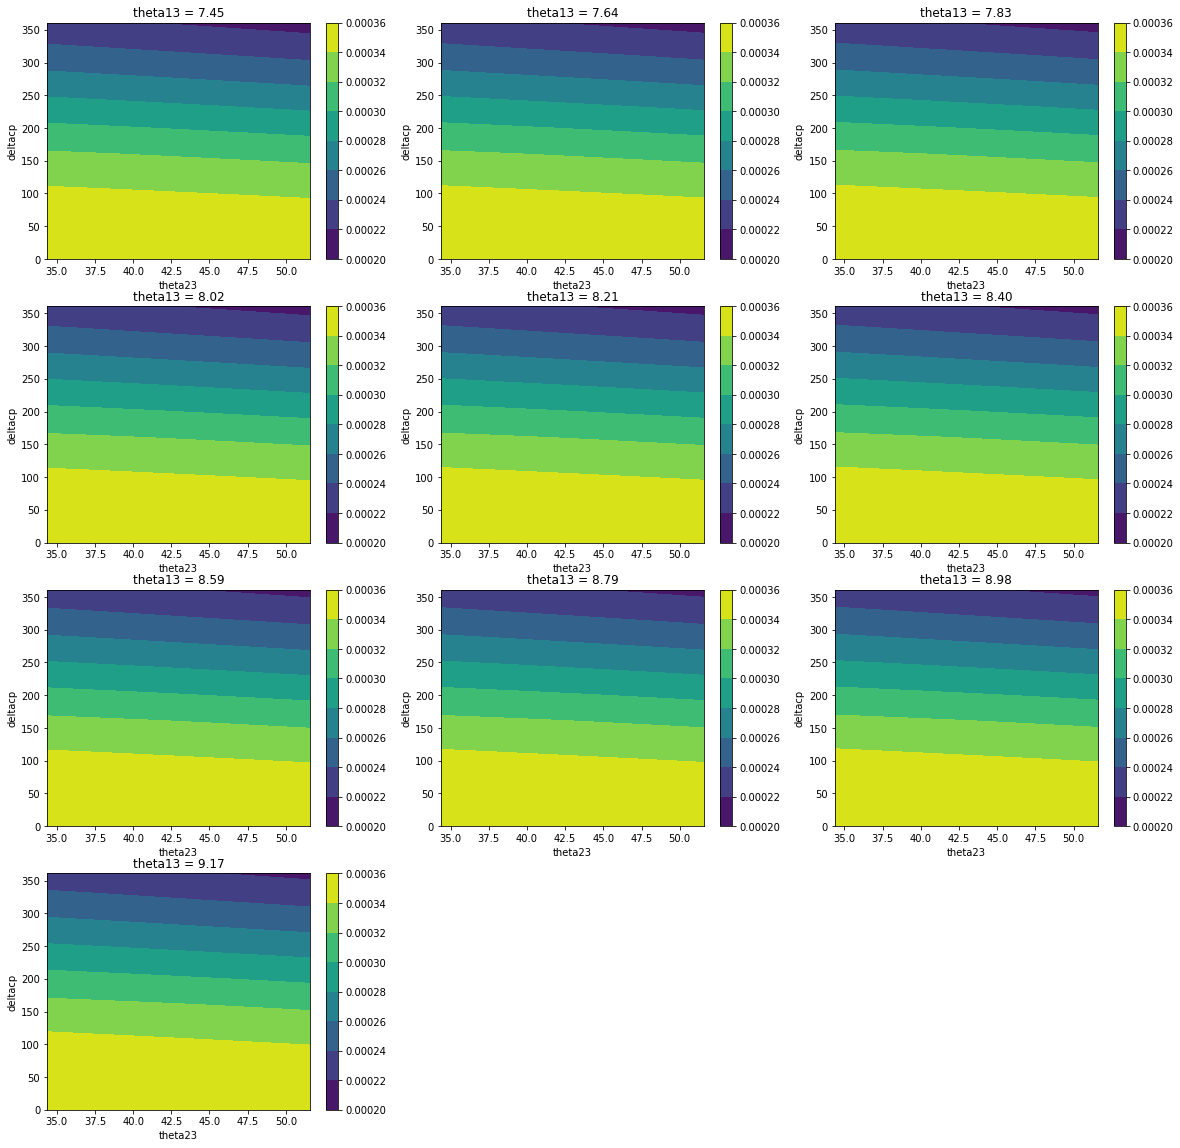

In [20]:
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(4, 3, i+1)
    plt.contourf(ygrid[i].numpy()*180/np.pi, zgrid[i].numpy()*180/np.pi, prob[i].numpy())
    plt.title('theta13 = {:.2f}'.format((xline[i]*180/np.pi)))
    plt.xlabel('theta23')
    plt.ylabel('deltacp')
    plt.colorbar()
plt.show()